# Supervised Topic modelling :


This is a multi-class classification problem. 

- input data : the post (title and content)
- labels : associated tags  

We downloaded tags that correspond to each stackOverflow post. This is our target set.
The number of classes outputs is the number of different label present in the label corpus.

**Preprocessing** :


To avoid the curse of dimensionality issue (as our word corpus is very large) we will use prior LSA and word-embedding representation technique.


**Model Benchmark**

- Logistic regression : one-vs-rest
- SVM 
- Random forest 
- NN with prior embeddings : in the second supervised notebook
with three different prior embeddings : Word2VEc, BERT and USE

All the models will be compared and selected upon the **average_precision_scores** and	**jaccard_scores**.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from  tm_common import * 
IN_COLAB, output_dir = tm_get_working_config()

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# word count
import gensim
import gensim.corpora as corpora
from gensim.models import Word2Vec

from scipy.sparse import csr_matrix
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.decomposition import TruncatedSVD

from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import multilabel_confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import jaccard_score, average_precision_score


In [4]:
sto_corpus = np.load(f"{output_dir}corpus.npy",allow_pickle=True)
sto_corpus_tags = np.load(f"{output_dir}corpus_tags.npy",allow_pickle=True)

sto_titles = np.load(f"{output_dir}bag_of_words_titles.npy",allow_pickle=True)
sto_body = np.load(f"{output_dir}bag_of_words_body.npy",allow_pickle=True)

In [5]:
sto_corpus = sto_corpus
sto_titles = sto_titles
sto_body = sto_body
sto_corpus_tags = sto_corpus_tags

## Number of classes
I want to focus on main tags, therefore thanks to the graphic above I selected **30 tags**.


In [6]:
tags = []
for text_tags in sto_corpus_tags:
    tags.extend(iter(text_tags))
    
tags_series = pd.Series(tags)

labels = tags_series.value_counts().head(30)
labels

c#                4823
java              4696
c++               3957
javascript        3847
python            3337
android           2667
ios               2388
.net              2007
php               1787
c                 1738
html              1668
jquery            1442
performance       1299
css               1148
objective-c       1036
c++11              971
asp.net            919
node.js            915
sql                883
algorithm          872
linux              868
spring             865
multithreading     780
iphone             768
swift              758
mysql              742
windows            675
json               666
arrays             659
xcode              586
Name: count, dtype: int64

In [7]:
# each label is associated to an id between 0 and 29 by a dictionary
label_list = np.array(labels.index)
d = dict(zip(label_list, range(0,len(label_list))))

# The Multi-Label classification :

Multi-label classification is different from Multi-class classification.  In multi-class classification, each instance belong to a specific label, in multi-label classification, an instance may belong to 0 to multiple classes.

Here, each instance of our dataset has multiple labels. The prediction is therefore **mutually non-exclusive**.
We need a model that can predict zero or more class.

In [8]:
# multi-label classification
def retrieve_tag_in_selected_list(tags_list, selection_list):
  tags_list_selection = []
  for tags in tags_list:
    tmp = [ d[tag] for tag in tags if tag in selection_list  ]
    tags_list_selection.append( tmp )
  return tags_list_selection

Y_n = retrieve_tag_in_selected_list(sto_corpus_tags, labels)


In [9]:
Y_n[:10]

[[4, 19], [9, 28], [3, 8], [1], [3, 8], [6], [0, 7, 2], [26], [2, 9], [18]]

## X_train, X_test, Y_train, Y_test slip

This is done before tfidf to avoid data leakage

In [10]:
(
    X_corpus_train,
    X_corpus_test,
    X_title_train,
    X_title_test,
    X_body_train,
    X_body_test,
    y_train,
    y_test,
) = train_test_split(sto_corpus, sto_titles, sto_body, Y_n, test_size=0.2, random_state=1)

In [11]:
np.save(f"{output_dir}X_corpus_train.npy",X_corpus_train,   allow_pickle=True)
np.save(f"{output_dir}X_corpus_test.npy", X_corpus_test,   allow_pickle=True)

np.save(f"{output_dir}X_title_train.npy", X_title_train, allow_pickle=True)
np.save(f"{output_dir}X_title_test.npy",  X_title_test, allow_pickle=True)

np.save(f"{output_dir}X_body_train.npy",X_body_train,   allow_pickle=True)
np.save(f"{output_dir}X_body_test.npy", X_body_test,   allow_pickle=True)

np.save(f"{output_dir}y_train.npy",       y_train, allow_pickle=True)
np.save(f"{output_dir}y_test.npy",        y_test,   allow_pickle=True)
np.save(f"{output_dir}label_list.npy",    label_list,   allow_pickle=True)


c:\dev\topic_modelling\lib\site-packages\numpy\lib\npyio.py:521: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


Here, we only consider 25% of our original dataset to leverage computations. With further computational power that part can be retrieve. 

In [12]:
size_train = len(X_body_train) // 4 
size_test = len(X_corpus_test) // 4 
print(len(X_body_train) , size_train)
print(len(X_corpus_test) , size_test)

24729 6182
6183 1545


In [13]:
size_train = len(X_body_train) // 4 
size_test = len(X_corpus_test) // 4 
X_title_train, X_body_train, X_corpus_train, y_train = X_title_train[:size_train], X_body_train[:size_train], X_corpus_train[:size_train] , y_train[:size_train]
X_title_test, X_corpus_test, X_body_test, y_test = X_title_test[:size_test], X_corpus_test[:size_test], X_body_test[:size_test], y_test[:size_test]


In [14]:
print( len(X_title_train) )
print( len(X_corpus_train) )
print( len(X_title_test) )
print( len(y_test)       )

6182
6182
1545
1545


In [15]:
y_test[:5]

[[10, 13], [13], [6, 23], [9], [4]]

# Label preprocessing : 


We need to translate our tags to membership array. This is like a one-hot encoding for the target. 

In [16]:
mlb = MultiLabelBinarizer()
y_train_b = mlb.fit_transform(y_train)
y_test_b = mlb.transform(y_test)

## Handling body and title :

The idea is that we can use differently the body and title with : 
- only body 
- only title
- simple concatenation 
- more weights apply to title

Here we will test all techniques with the logistic regression and study the different outputs scores. 

In [17]:
# simple concatenation
X_train = [
    np.append(X_title_train[i], X_body_train[i]) for i in range(len(X_title_train))
]
X_test = [np.append(X_title_test[i], X_body_test[i]) for i in range(len(X_title_test))]

X_train_biased_towards_title = [
    np.concatenate((np.repeat(X_title_train[i], 5), X_body_train[i]))
    for i in range(len(X_title_train))
]
X_test_biased_towards_title = [
    np.concatenate((np.repeat(X_title_train[i], 5), X_body_test[i]))
    for i in range(len(X_title_test))
]

# Dummy classifier 

In [18]:
dummy_clf = MultiOutputClassifier(DummyClassifier(strategy="most_frequent"))
dummy_clf.fit(X_train, y_train_b)
y_pred = dummy_clf.predict(X_test) 
precision_dummy = average_precision_score(y_test_b, y_pred, average="micro")
jaccard_score_dummy = jaccard_score(y_test_b, y_pred, average="micro")

# Logistic regression : One VS Rest

In [71]:
def logistic_reg_train(X_train_svd, y_train_b):
    model = MultiOutputClassifier(LogisticRegression(multi_class="ovr"))
    model.fit(X_train_svd, y_train_b)
    return model


## Evaluation :    


In [20]:
def get_logistic_score(X_train, X_test, return_yhat=False):
    X_svd_train, X_svd_test = tfidf_lsa_preprocessing(X_train, X_test)
    model = logistic_reg_train(X_svd_train, y_train_b)
    yhat = model.predict(X_svd_test)
    precision_logistic = average_precision_score(y_test_b, yhat, average="micro")
    jaccard_score_logistic = jaccard_score(y_test_b, yhat, average="micro")
    if return_yhat:
        return precision_logistic, jaccard_score_logistic, yhat
    return precision_logistic, jaccard_score_logistic


precision_logistic_body_only, jaccard_score_logistic_body_only = get_logistic_score(
    X_body_train, X_body_test
)
precision_logistic_title_only, jaccard_score_logistic_title_only = get_logistic_score(
    X_title_train, X_title_test
)
precision_logistic_concatenation, jaccard_score_logistic_concatenation= get_logistic_score(X_train, X_test)

In [21]:
precision_logistic_biased, jaccard_score_logistic_biased = get_logistic_score(X_train_biased_towards_title, X_test_biased_towards_title)

In [22]:
avg_precision_scores = [
    precision_logistic_body_only,
    precision_logistic_title_only,
    precision_logistic_concatenation,
    precision_logistic_biased,

]
jaccard_scores = [
    jaccard_score_logistic_body_only,
    jaccard_score_logistic_title_only,
    jaccard_score_logistic_concatenation,
    jaccard_score_logistic_biased,
]

result = pd.DataFrame(
    {
        "average_precision_scores": avg_precision_scores,
        "jaccard_scores": jaccard_scores,
    },
    index=[
        "logistic : body only",
        "logistic : title only",
        "logistic : concatenation",
        "logistic : biased towards title",
    ],
)
result

,average_precision_scores,jaccard_scores
logistic : body only,0.184476,0.159657
logistic : title only,0.156712,0.119161
logistic : concatenation,0.196039,0.170827
logistic : biased towards title,0.104996,0.079059


Concatenation of body and title obtains a better scores than other techniques. The biasness towards the title is not relevant here. 

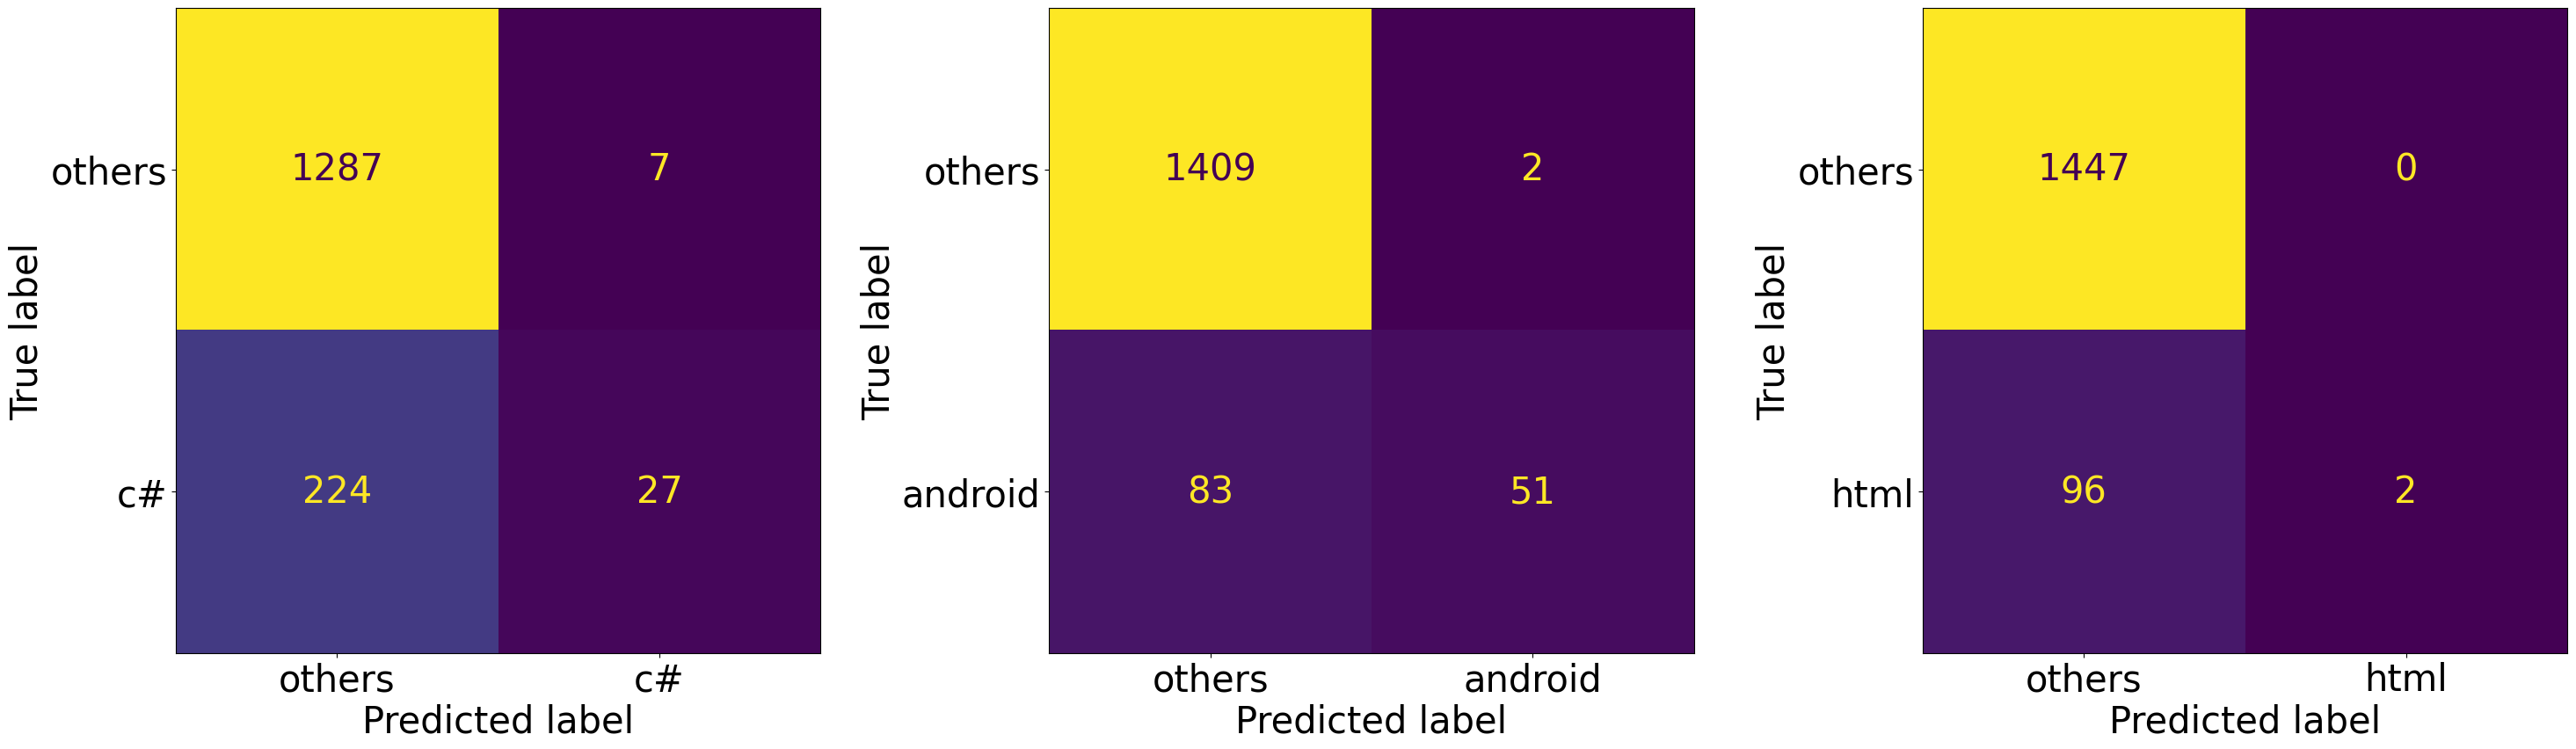

In [73]:
_, _, yhat=  get_logistic_score( X_title_train, X_title_test, return_yhat=True)
plot_confusion_matrix(y_test_b, yhat, label_list)

I was expecting that the class with the highest support (meaning the most represented tags) would have the best precision scores. It is not the case here. The precision seems more coherent with tags that are really specific and not in intersection with others such as python and node.js compared to C++ and c++11. 

In [ ]:
print(classification_report(y_test_b, yhat, target_names=label_list, digits=2))

                precision    recall  f1-score   support

            c#       0.79      0.11      0.19       251
          java       0.95      0.32      0.48       236
           c++       0.65      0.07      0.13       176
    javascript       0.92      0.12      0.21       205
        python       1.00      0.26      0.41       174
       android       0.96      0.38      0.55       134
           ios       0.86      0.05      0.10       110
          .net       1.00      0.02      0.05       123
           php       0.75      0.04      0.07        79
             c       0.00      0.00      0.00        86
          html       1.00      0.02      0.04        98
        jquery       1.00      0.15      0.26        66
   performance       0.86      0.08      0.14        77
           css       0.00      0.00      0.00        68
   objective-c       0.00      0.00      0.00        39
         c++11       1.00      0.02      0.04        46
       asp.net       1.00      0.03      0.06  

c:\dev\topic_modelling\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\dev\topic_modelling\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## SVM : Support Vector Classification (SVC) one vs one

In [45]:
# test title only at input
def get_svm_score(X_train, X_test):
    X_svd_train, X_svd_test = tfidf_lsa_preprocessing(X_train, X_test)
    regressor = MultiOutputClassifier(
        svm.SVC(decision_function_shape="ovo", kernel="rbf")
    )
    regressor.fit(X_svd_train, y_train_b)
    y_pred = regressor.predict(X_svd_test)
    precision_svm = average_precision_score(y_test_b, y_pred, average="micro")
    jaccard_score_svm = jaccard_score(y_test_b, y_pred, average="micro")

    return precision_svm, jaccard_score_svm, y_pred


precision_svm_title_only, jaccard_score_svm_title_only, y_pre_title_only = get_svm_score(X_title_train, X_title_test)

In [46]:
# test concatenation 
precision_svm, jaccard_score_svm, y_pred_concat = get_svm_score(X_train, X_test)

In [64]:
avg_precision_scores = [precision_svm_title_only,precision_svm]
jaccard_scores = [jaccard_score_svm_title_only,jaccard_score_svm ]
result = pd.DataFrame(
    {
        "average_precision_scores": avg_precision_scores,
        "jaccard_scores": jaccard_scores,
    },
    index=[
        "SVM : title only ",
        "SVM : concatenation ",
    ],
)
result

,average_precision_scores,jaccard_scores
SVM : title only,0.241663,0.225222
SVM : concatenation,0.422422,0.434641


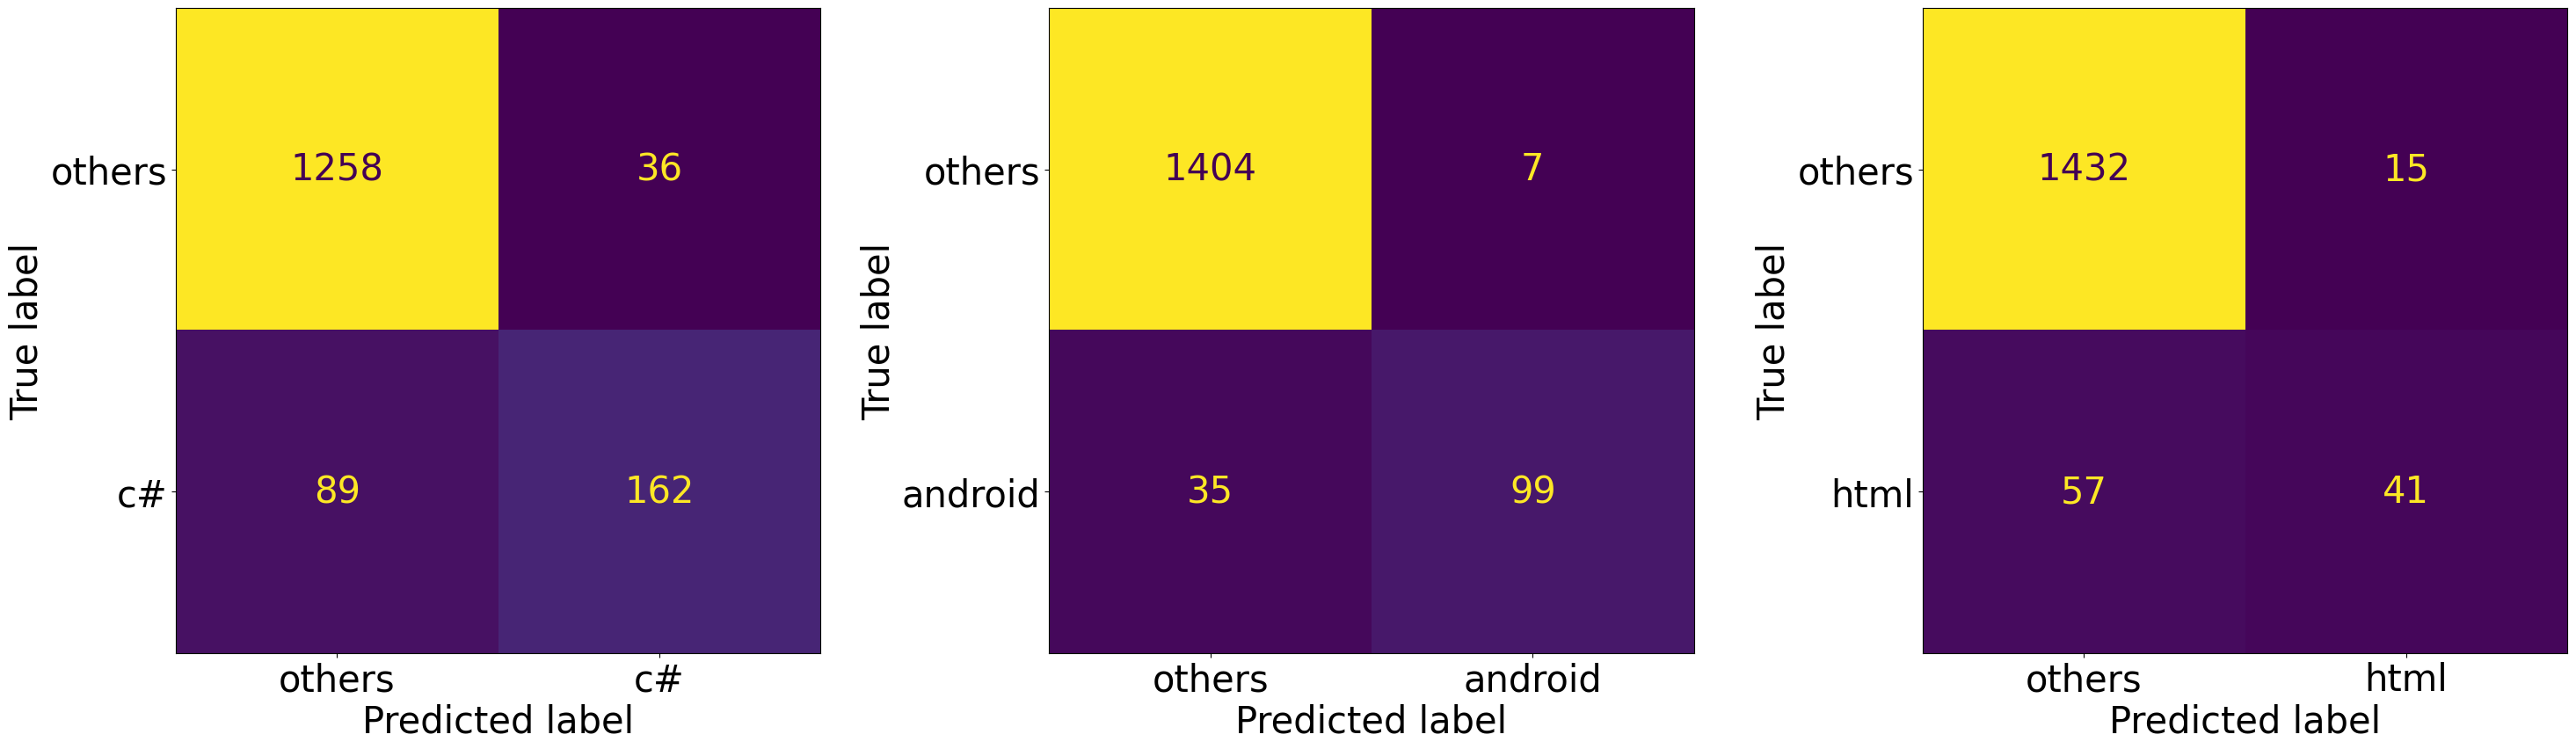

In [74]:
plot_confusion_matrix(y_test_b, y_pred_concat, label_list)

In [49]:
print(classification_report(y_test_b, y_pred_concat, target_names=label_list, digits=2))

                precision    recall  f1-score   support

            c#       0.82      0.65      0.72       251
          java       0.87      0.68      0.76       236
           c++       0.78      0.61      0.68       176
    javascript       0.75      0.62      0.68       205
        python       0.95      0.75      0.84       174
       android       0.93      0.74      0.83       134
           ios       0.88      0.63      0.73       110
          .net       0.62      0.11      0.18       123
           php       0.92      0.29      0.44        79
             c       0.75      0.42      0.54        86
          html       0.73      0.42      0.53        98
        jquery       0.80      0.53      0.64        66
   performance       0.85      0.14      0.24        77
           css       0.81      0.38      0.52        68
   objective-c       0.62      0.21      0.31        39
         c++11       0.77      0.22      0.34        46
       asp.net       0.67      0.11      0.20  

c:\dev\topic_modelling\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Random forest

## Consecutive grid-search for hyperparameters tunning :

In [50]:
X_svd_train, X_svd_test = tfidf_lsa_preprocessing(X_train, X_test)

The hyper-parameter tunning is very long to run. I choose to compute it for a subset. 

If the model is the one achieving the best performance then I will tune it on the all train set. 

In [51]:
FIT_RANDOM_FOREST = False
if FIT_RANDOM_FOREST : 
    n_estimators = [20, 50]  # number of trees in the random forest
    max_depth = [2 ,5, 10]  # maximum number of levels allowed in each decision tree
    min_samples_split = [2, 6, 10]  # minimum sample number to split a node
    min_samples_leaf = [1, 3, 4]  # minimum sample number that can be stored in a leaf node

    random_grid = {
        "n_estimators": n_estimators,
        "max_depth": max_depth,
        "min_samples_split": min_samples_split,
        "min_samples_leaf": min_samples_leaf,
    }

    rf = RandomForestRegressor()
    grid_seach_rf = GridSearchCV(rf, random_grid)  #  default 5-fold cross validation,

    grid_seach_rf.fit(X_svd_train[:300], y_train_b[:300])
    best_params = grid_seach_rf.best_params_
    print("Random grid: ", grid_seach_rf, "\n")
    print("Best Parameters: ", grid_seach_rf.best_params_, " \n")
else : 
    best_params =   {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 50}  


In [52]:

RF_MAX_DEPTH = best_params.get('max_depth')
RF_N  = best_params.get('n_estimators')
RF_MIN_SAMPLE_LEAF =  best_params.get('min_samples_leaf')
RF_MIN_SAMPLES_SPLIT= best_params.get('min_samples_split')

In [53]:
rf = RandomForestRegressor(oob_score=True,
                        min_samples_leaf=RF_MIN_SAMPLE_LEAF, 
                        min_samples_split=RF_MIN_SAMPLES_SPLIT,
                        n_estimators=RF_N,
                        max_depth=RF_MAX_DEPTH)
rf.fit(X_svd_train, y_train_b)

RandomForestRegressor(max_depth=10, min_samples_leaf=4, n_estimators=50,
                      oob_score=True)

In [54]:
y_train_pred = rf.predict(X_svd_train)
threshold_test = tm_test_threshold(y_train_b, y_train_pred)  

Random Forest does not output a binary decision but a probability of class membership. To obtain a classification we need a decision threshold. Let's tune it on the train test to obtain the best precision possible : 

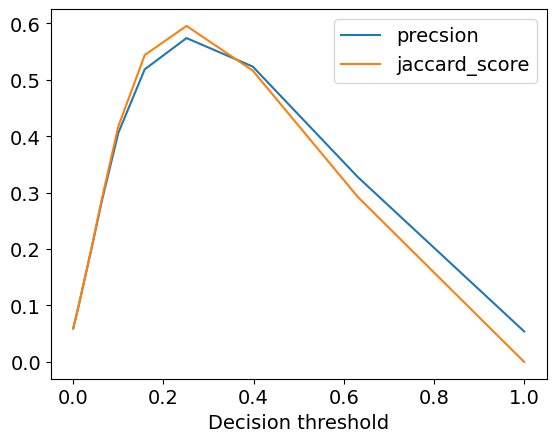

In [63]:
tm_plot_threshold_test(threshold_test)

In [56]:
max_config = threshold_test.query('precision == precision.max()')
t = max_config["threshold"]
best_t =  t.values[0]
best_t

0.25118864315094075

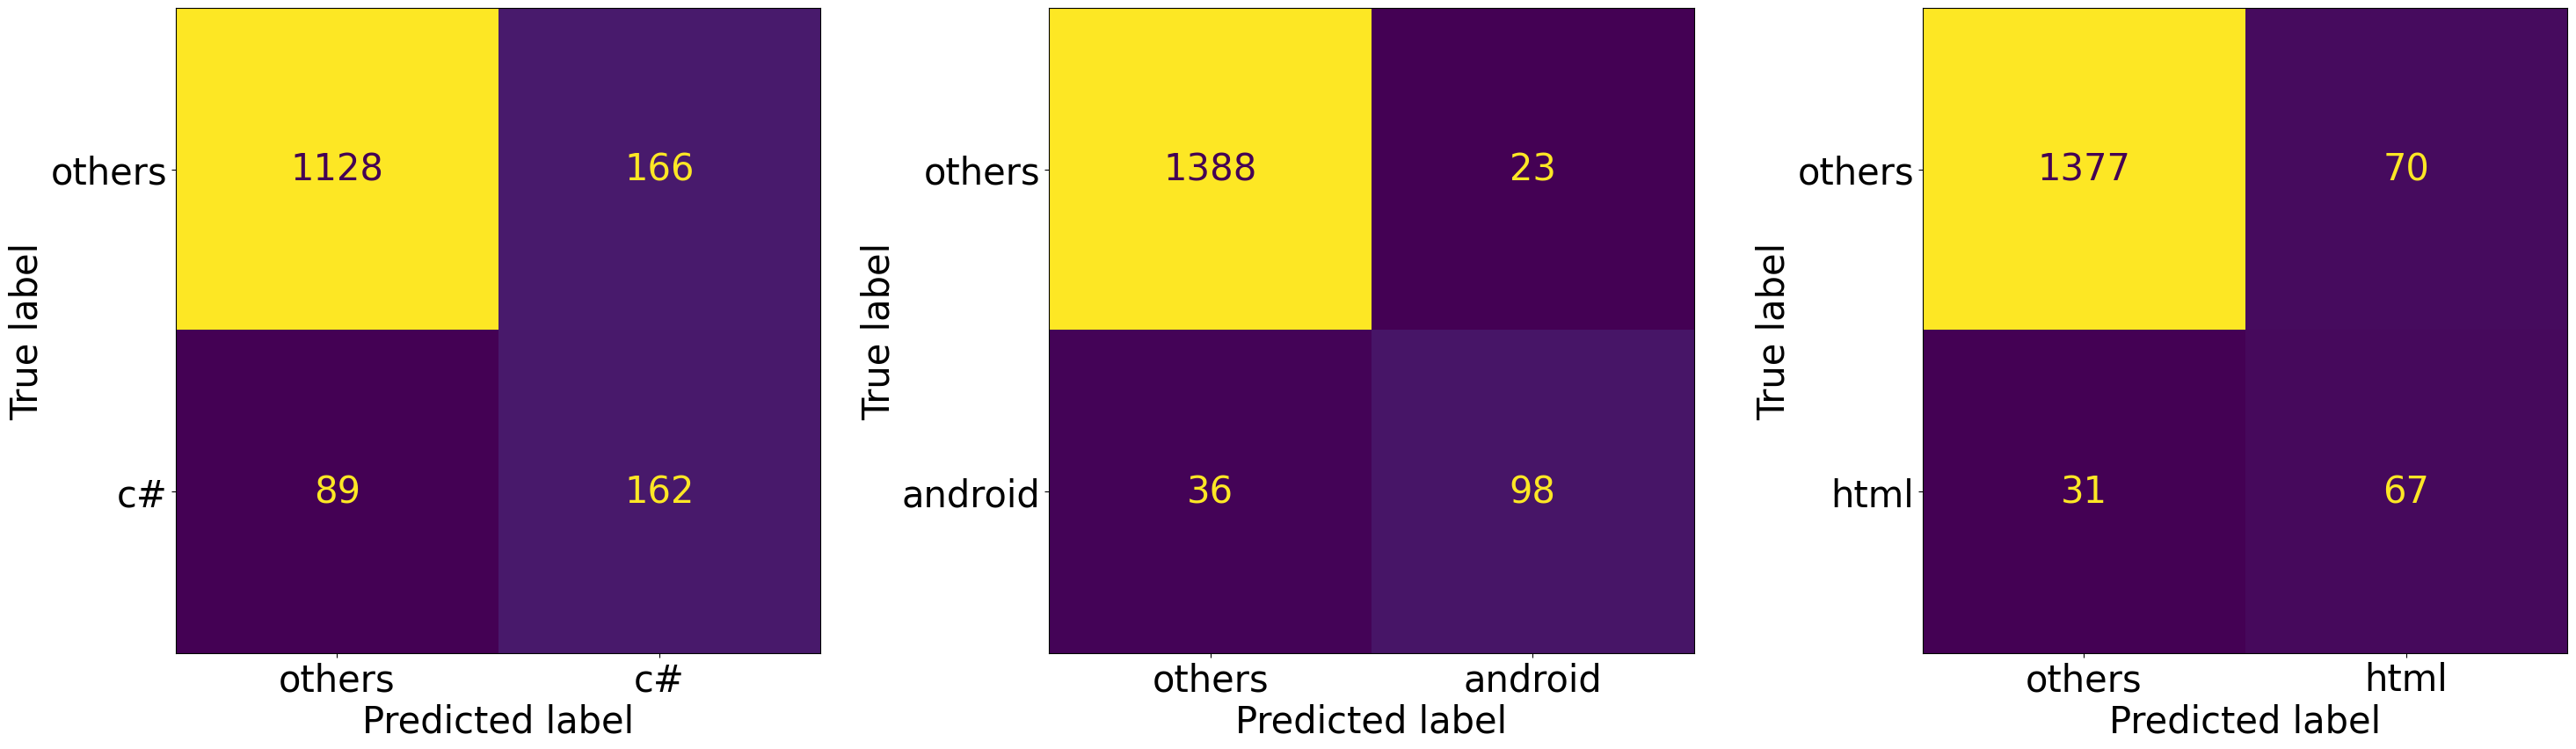

In [62]:
y_pred_rf = rf.predict(X_svd_test)
y_pred_rf = (y_pred_rf > best_t).astype(np.float32)
plot_confusion_matrix(y_test_b, y_pred_rf, label_list)

In [58]:
precision_rf      = average_precision_score(y_test_b, y_pred_rf, average='micro')
jaccard_score_rf = jaccard_score(y_test_b, y_pred_rf, average='micro')

## Evaluation 

In [59]:
avg_precision_scores = [
    precision_dummy,
    precision_logistic_concatenation,
    precision_svm,
    precision_rf,
]
jaccard_scores = [
    jaccard_score_dummy,
    jaccard_score_logistic_concatenation,
    jaccard_score_svm,
    jaccard_score_rf,
]

result = pd.DataFrame(
    {
        "average_precision_scores": avg_precision_scores,
        "jaccard_scores": jaccard_scores,
    },
    index=[
        "Dummy classifier",
        "logistic : concatenation",
        "SVM : concatenation ",
        "RandomForest",
    ],
)
result.to_csv(f"{output_dir}result_supervised1.csv")

In [60]:
result.to_csv(f"{output_dir}/supervised_1_results.csv")
result

,average_precision_scores,jaccard_scores
Dummy classifier,0.053830,0.000000
logistic : concatenation,0.196039,0.170827
SVM : concatenation,0.422422,0.434641
RandomForest,0.321323,0.372925


This is a intermediary results. We will compare these scores to the NN approach and to the unsupervised learning one. 